In [1]:
from torchvision import transforms
from torch.utils.data import DataLoader

from utils.dataset import CustomDataset
from torchsampler import ImbalancedDatasetSampler

import torch
import torch.nn as nn
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np 

from torchsummary import summary

from torch.nn import functional as F 

from tqdm import tqdm
import pandas as pd 

import matplotlib.pyplot as plt

import sys
sys.path.append('../../')
from network import binary_models as models


In [2]:
test_dir1 = '/mnt/HDD/octc/data_bin_origin/test'
# test_dir2 = '/mnt/HDD/octc/data_bin_origin/test'
# test_dir3 = '/mnt/HDD/octc/data_bin_origin/test'
test_dir2 = '/mnt/HDD/octc/data_bin_sono/test'
test_dir3 = '/mnt/HDD/oci-gan/oci-gan_v1_bin/test'
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224), antialias=True),
    transforms.Grayscale(num_output_channels=3),
])
test_batch = 16
test_dataset1 = CustomDataset(root_dir = test_dir1, transform= test_transform)
test_dataset2 = CustomDataset(root_dir = test_dir2, transform= test_transform)
test_dataset3 = CustomDataset(root_dir = test_dir3, transform= test_transform)
test_dataset4 = CustomDataset(root_dir = test_dir1, transform= test_transform)
test_dataset5 = CustomDataset(root_dir = test_dir2, transform= test_transform)
test_dataset6 = CustomDataset(root_dir = test_dir3, transform= test_transform)
test_loader1 = DataLoader(dataset = test_dataset1, batch_size = test_batch, shuffle= True)
test_loader2 = DataLoader(dataset = test_dataset2, batch_size = test_batch, shuffle= True)
test_loader3 = DataLoader(dataset = test_dataset3, batch_size = test_batch, shuffle= True)
test_loader4 = DataLoader(dataset = test_dataset4, batch_size = test_batch, shuffle= True)
test_loader5 = DataLoader(dataset = test_dataset5, batch_size = test_batch, shuffle= True)
test_loader6 = DataLoader(dataset = test_dataset6, batch_size = test_batch, shuffle= True)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Convnext
checkpoint_path1 = '/home/eiden/eiden/octc-classification/models/binary/convnext_origin_240406/convnext_origin_240406_50.pt' #original model
checkpoint_path2 = '/home/eiden/eiden/octc-classification/models/binary/convnext_sono_240406/convnext_sono_240406_50.pt' #not inpainting just sono model
checkpoint_path3 = '/home/eiden/eiden/octc-classification/models/binary/convnext_ours_240406/convnext_ours_240406_50.pt' #Ours model
test_model1 = models.pretrained_convnext_binary().to(device) 
test_model2 = models.pretrained_convnext_binary().to(device) 
test_model3 = models.pretrained_convnext_binary().to(device) 

### Swin-T
checkpoint_path4 = '/home/eiden/eiden/octc-classification/models/binary/swin_origin_240406/swin_origin_240406_50.pt' #original model
checkpoint_path5 = '/home/eiden/eiden/octc-classification/models/binary/swin_sono_240406/swin_sono_240406_50.pt' #not inpainting just sono model
checkpoint_path6 = '/home/eiden/eiden/octc-classification/models/binary/swin_ours_240406/swin_ours_240406_50.pt' #Ours model
test_model4 = models.pretrained_swin_binary().to(device) 
test_model5 = models.pretrained_swin_binary().to(device) 
test_model6 = models.pretrained_swin_binary().to(device) 


test_model1.load_state_dict(state_dict = torch.load(checkpoint_path1)['model_state_dict'])
test_model2.load_state_dict(state_dict = torch.load(checkpoint_path2)['model_state_dict'])
test_model3.load_state_dict(state_dict = torch.load(checkpoint_path3)['model_state_dict'])
test_model4.load_state_dict(state_dict = torch.load(checkpoint_path4)['model_state_dict'])
test_model5.load_state_dict(state_dict = torch.load(checkpoint_path5)['model_state_dict'])
test_model6.load_state_dict(state_dict = torch.load(checkpoint_path6)['model_state_dict'])
print(f'load complete!! device : {device}')

/home/eiden/anaconda3/envs/eiden/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


load complete!! device : cuda


In [4]:
true_labels1,true_labels2,true_labels3 = [],[],[] 
pred_labels1,pred_labels2,pred_labels3 = [],[],[]
pred_scores1,pred_scores2,pred_scores3 = [],[],[]
true_labels4,true_labels5,true_labels6 = [],[],[] 
pred_labels4,pred_labels5,pred_labels6 = [],[],[]
pred_scores4,pred_scores5,pred_scores6 = [],[],[]

metrics_dict1 = {'model_name' : ['[Convext] Original Image'], "recall": [], "specificity": [], "ppv": [], "npv": [], "f1_score": [], "acc": [], "roc_auc_score": [], "Best Threshold" : None}
metrics_dict2 = {'model_name' : ['[Convext] Traiditonal Image'], "recall": [], "specificity": [], "ppv": [], "npv": [], "f1_score": [], "acc": [], "roc_auc_score": [], "Best Threshold" : None}
metrics_dict3 = {'model_name' : ['[Convext] Ours Image'], "recall": [], "specificity": [], "ppv": [], "npv": [], "f1_score": [], "acc": [], "roc_auc_score": [], "Best Threshold" : None}
metrics_dict4 = {'model_name' : ['[Swin-T] Original Image'], "recall": [], "specificity": [], "ppv": [], "npv": [], "f1_score": [], "acc": [], "roc_auc_score": [], "Best Threshold" : None}
metrics_dict5 = {'model_name' : ['[Swin-T] Traiditonal Image'], "recall": [], "specificity": [], "ppv": [], "npv": [], "f1_score": [], "acc": [], "roc_auc_score": [], "Best Threshold" : None}
metrics_dict6 = {'model_name' : ['[Swin-T] Ours Image'], "recall": [], "specificity": [], "ppv": [], "npv": [], "f1_score": [], "acc": [], "roc_auc_score": [], "Best Threshold" : None}
# metrics_dict3 = {'model_name' : [checkpoint_path3.split('/binary/')[-1].split('/')[0]], "recall": [], "specificity": [], "ppv": [], "npv": [], "f1_score": [], "acc": [], "roc_auc_score": [], "Best Threshold" : None}

In [5]:
from utils.metrics import metric_abstract, metric_func, save_metric, plot_combined_roc_curves, delong_test
def test(test_model, test_loader, metrics_dict, true_labels, pred_scores):
    with torch.no_grad():
        test_model.eval()
        for _, (inputs, labels, dirs) in tqdm(enumerate(test_loader)):
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = test_model(inputs)
            
            # Update metrics for each model
            true_labels, pred_scores = metric_abstract(labels, outputs, pred_scores, true_labels)
            
        metrics_dict = metric_func(true_labels, pred_scores, metrics_dict)
    return true_labels, pred_scores, metrics_dict

true_labels1, pred_scores1, metrics_dict1 = test(test_model1, test_loader1, metrics_dict1, true_labels1, pred_scores1)
true_labels2, pred_scores2, metrics_dict2 = test(test_model2, test_loader2, metrics_dict2, true_labels2, pred_scores2)
true_labels3, pred_scores3, metrics_dict3 = test(test_model3, test_loader3, metrics_dict3, true_labels3, pred_scores3)
true_labels4, pred_scores4, metrics_dict4 = test(test_model4, test_loader4, metrics_dict4, true_labels4, pred_scores4)
true_labels5, pred_scores5, metrics_dict5 = test(test_model5, test_loader5, metrics_dict5, true_labels5, pred_scores5)
true_labels6, pred_scores6, metrics_dict6 = test(test_model6, test_loader6, metrics_dict6, true_labels6, pred_scores6)

19it [00:02,  7.27it/s]


3.749169e-05


19it [00:02,  8.09it/s]


9.741592e-05


19it [00:03,  5.67it/s]


1.4162891e-05


19it [00:02,  7.55it/s]


3.5095559e-06


19it [00:02,  8.23it/s]


8.766061e-06


19it [00:03,  5.73it/s]

2.0411386e-07


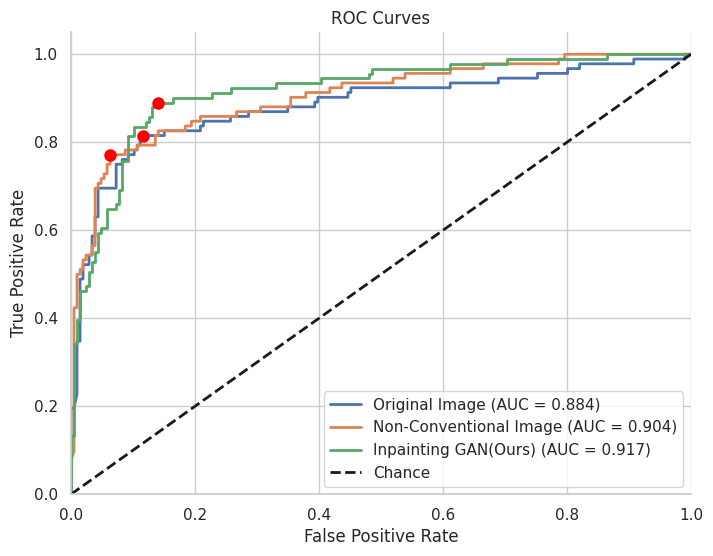

In [6]:
models_data = [
    (true_labels1, pred_scores1, 'Original Image'),
    (true_labels2, pred_scores2, 'Non-Conventional Image'),
    (true_labels3, pred_scores3, 'Inpainting GAN(Ours)'),
    # (true_labels4, pred_scores4, metrics_dict4['model_name'][0]),
    # (true_labels5, pred_scores5, metrics_dict5['model_name'][0]),
    # (true_labels6, pred_scores6, metrics_dict6['model_name'][0]),
]
plot_combined_roc_curves(models_data)



In [7]:
# delong test 
z_score1_3, p_value1_3 = delong_test(pred_scores1, pred_scores3, true_labels1, true_labels3)
z_score1_2, p_value1_2 = delong_test(pred_scores1, pred_scores2, true_labels1, true_labels2)
z_score2_3, p_value2_3 = delong_test(pred_scores2, pred_scores3, true_labels2, true_labels3)
print(f"Original vs Ours : {z_score1_3, p_value1_3 }")
print(f"Original vs Non-Conventional : {z_score1_2, p_value1_2 }")
print(f"Non-Conventional vs Ours : {z_score2_3, p_value2_3 }")

Original vs Ours : (-1.0332356026456273, 0.30149365542518924)
Original vs Non-Conventional : (-0.6150970948296701, 0.5384906005483094)
Non-Conventional vs Ours : (-0.4208087428525948, 0.6738947469382441)


In [ ]:
# Save metrics
save_path = os.path.join('/home/eiden/eiden/octc-classification/models/binary_metric')
save_metric(metrics_dict1, os.path.join(save_path, metrics_dict1['model_name'][0])+'.csv')
save_metric(metrics_dict2, os.path.join(save_path, metrics_dict2['model_name'][0])+'.csv')
save_metric(metrics_dict3, os.path.join(save_path, metrics_dict3['model_name'][0])+'.csv')
save_metric(metrics_dict4, os.path.join(save_path, metrics_dict4['model_name'][0])+'.csv')
save_metric(metrics_dict5, os.path.join(save_path, metrics_dict5['model_name'][0])+'.csv')
save_metric(metrics_dict6, os.path.join(save_path, metrics_dict6['model_name'][0])+'.csv')

In [ ]:
import os
import pandas as pd

# CSV 파일 목록 가져오기
csv_dir = save_path
csv_li = os.listdir(csv_dir)
csv_li = [csv for csv in csv_li if csv.endswith('.csv')]

# CSV 파일 읽기 및 데이터프레임에 추가
df = pd.DataFrame()
for csv in csv_li:
    csv_path = os.path.join(csv_dir, csv)
    if os.path.getsize(csv_path) > 0:  # 파일이 비어 있지 않은 경우에만 읽기
        temp = pd.read_csv(csv_path)
        df = pd.concat([df, temp], axis=0)

# 인덱스 리셋하기 (기존 인덱스 제거)
# df.reset_index(drop=True, inplace=True)
# 'model_name' 열에서 선행하는 0 제거
# df['model_name'] = df['model_name'].apply(lambda x: x.lstrip('0'))
df.index = df.index.map(lambda x: str(x).lstrip('0'))
df = df.sort_values(by='model_name', ascending=True)
df


In [ ]:
def find_all_files(directory):
    file_paths = []  # 모든 파일 경로를 저장할 리스트
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_paths.append(os.path.join(root, file))  # 파일 경로를 리스트에 추가
    return file_paths


In [ ]:
from utils.xai import apply_gradcam
model_paths = [test_model1, test_model2, test_model3]
checkpoint_paths = [checkpoint_path1, checkpoint_path2, checkpoint_path3]
model_name = ['Original', 'Traditional', 'Ours']


# dir_li1 = find_all_files(test_dir1.replace('test', 'train')) #<---train set 
dir_li1 = find_all_files(test_dir1) #<---test set
dir_li2 = [path.replace('data_bin_origin', 'data_bin_sono') for path in dir_li1]
dir_li3 = [path.replace('octc/data_bin_origin', 'oci-gan/oci-gan_v1_bin') for path in dir_li1]

# gradcam_savedir = '/home/eiden/eiden/octc-classification/models/binary_metric/grad-cam/train'
# gradcam_savedir = '/home/eiden/eiden/octc-classification/models/binary_metric/grad-cam/test'

for i in range(len(dir_li1)):
    if dir_li1[i].split('/')[-1] != dir_li2[i].split('/')[-1] or dir_li1[i].split('/')[-1] != dir_li3[i].split('/')[-1]:
        pass
    else: 
        try:
            gradcam_input = []
            gradcam_result = []
            dir_li = [dir_li1[i], dir_li2[i], dir_li3[i]]
            for i in range(3):
                target_layer = model_paths[i].base_model.features[-1][-1]# convext
                # target_layer = model_paths[i].base_model.layers[-1].blocks  #swin-t
                image_path = dir_li[i]

                # # Grad-CAM을 적용할 이미지 경로 
                original_img, overlayed_img = apply_gradcam(model_paths[i], image_path, target_layer, device, model_name[i])
                gradcam_input.append(original_img)
                gradcam_result.append(overlayed_img)
                # # Grad-CAM 결과를 저장할 경로 설정
                save_gradcam_path = os.path.join(save_path, os.path.basename(checkpoint_paths[i]) + '_gradcam.jpg')

            # Grad-CAM 결과 시각화
            fig, axes = plt.subplots(2, 3, figsize=(10, 5))  # 2x3 subplot 생성

            for i, result in enumerate(gradcam_input):
                axes[0, i].imshow(result)  # 첫 번째 행에 결과 표시
                axes[0, i].axis('off')
                axes[0, i].set_title(f'Data : {model_name[i]}')

            for i, result in enumerate(gradcam_result):
                axes[1, i].imshow(result)  # 두 번째 행에 결과 표시
                axes[1, i].axis('off')
                axes[1, i].set_title(f'Grad-CAM : {model_name[i]}')

            plt.tight_layout()
            plt.savefig('/home/eiden/eiden/octc-classification/models/binary_metric/grad-cam/'+os.path.basename(image_path).split('.')[0]+'.png', dpi=300)
            plt.close()
        except:
            pass